In [47]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

In [48]:
# Parameters
S0 = 100          # Initial stock price
K = 100           # Strike price
T = 1             # Time to expiration
r = 0.05          # Risk-free interest rate
sigma = 0.2       # Volatility
steps = 500_000     # Number of time steps
dt = T / steps    # Time step size
seed = 42         # For reproductibility

In [49]:
# Improved functions to accept put and call options

def black_scholes_price(S, K, T, r, sigma, is_call=True):
    if T <= 0:
        return max(0.0, S - K) if is_call else max(0.0, K - S)
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    return (2 * is_call - 1) * S * norm.cdf((2 * is_call - 1) * d1) + \
        (- 2 * is_call + 1) *  K * np.e ** (- r * T) * norm.cdf((2 * is_call - 1) * d2)

def black_scholes_delta(S, K, T, r, sigma, is_call=True):
    if T <= 0:
        if is_call:
            return 1.0 if S > K else 0.0
        else:
            return 0.0 if S > K else -1.0
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))

    return norm.cdf(d1) - (not is_call) # N(d1) - 1 if is_call = False

In [50]:

def initialize_simulation(S0, K, T, r, sigma,
                          option_pricer, # for instance, bs_price
                          option_delta, # for instance, bs_delta
                          portfolio_value = 0,
                          cash_account = 0,
                          shares_held = 0,
                          seed = None):

    if seed is not None:
        np.random.seed(seed)

    initial_option_price = option_pricer(S0, K, T, r, sigma)
    initial_delta = option_delta(S0, K, T, r, sigma)
    
    # Set up initial hedge portfolio
    shares_held = initial_delta
    cash_account = initial_option_price - shares_held * S0
    portfolio_value = cash_account + shares_held * S0 # Should be equal to initial_option_price

    # Store values for plotting
    stock_prices = [S0]
    option_prices = [initial_option_price]
    portfolio_values = [portfolio_value]
    deltas = [initial_delta]
    cash_accounts = [cash_account]
    shares_held_list = [shares_held]

    current_S = S0

    return initial_option_price, stock_prices, option_prices, portfolio_values, deltas, cash_accounts, shares_held_list, current_S


In [62]:
def dynamic_delta_hedging(current_S, K, T, r, sigma,
                          steps, 
                          stock_prices,
                          option_prices, 
                          portfolio_values, 
                          deltas, 
                          cash_accounts, 
                          shares_held_list,
                          option_pricer,
                          option_delta):

    for i in range(1, steps + 1):
        time_to_expiry = T - i * dt

        z = np.random.normal(0, 1)
        current_S = current_S * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)
        stock_prices.append(current_S)

        # Recalculate option price and delta

        current_option_price = option_pricer(current_S, K, time_to_expiry, r, sigma)
        option_prices.append(current_option_price)

        current_delta = option_delta(current_S, K, time_to_expiry, r, sigma) # This must be converted to a NN
        deltas.append(current_delta)

        delta_change = current_delta - shares_held_list[i - 1] # shares held is just shares_held_list[i - 1]
        shares_to_trade = delta_change

        # Trade shares and update cash account
        cash_accounts.append(cash_accounts[-1] - shares_to_trade * current_S)  # Buy shares (or sell if negative), cash decreases (or increases)
        shares_held_list.append(shares_held_list[-1] + shares_to_trade)

        # Let cash account grow with risk-free rate
        cash_accounts[i] *= np.exp(r * dt)

        # Update portfolio value
        portfolio_value = cash_accounts[i] + shares_held_list[i] * current_S
        portfolio_values.append(portfolio_value)

    return stock_prices, option_prices, portfolio_values, deltas, cash_accounts, shares_held_list, current_S
    



In [63]:
def PnL(current_S, portfolio_values, initial_option_price):
    # 3. Expiration Payoff
    option_payoff = np.maximum(0, current_S - K)
    final_portfolio_value = portfolio_values[-1]

    print(f"Initial Black-Scholes Option Price: {initial_option_price:.4f}")
    print(f"Final Portfolio Value (Hedge): {final_portfolio_value:.4f}")
    print(f"Option Payoff at Expiration: {option_payoff:.4f}")
    print(f"Difference between Final Portfolio Value and Option Payoff: {final_portfolio_value - option_payoff:.4f}")


In [64]:
# Initalize our simulation
(
    initial_option_price, stock_prices, option_prices, portfolio_values, 
    deltas, cash_accounts, shares_held_list, current_S
) = initialize_simulation(
    S0, K, T, r, sigma, black_scholes_price, black_scholes_delta, seed=seed
)

In [65]:

print(cash_accounts)

[np.float64(-53.232481545376345)]


In [66]:
# Dynamic delta hedging

(
    stock_prices, option_prices, portfolio_values, deltas, 
    cash_accounts, shares_held_list, current_S

)= dynamic_delta_hedging(current_S, K, T, r, sigma,
                          steps, 
                          stock_prices,
                          option_prices, 
                          portfolio_values, 
                          deltas, 
                          cash_accounts, 
                          shares_held_list,
                          black_scholes_price, 
                          black_scholes_delta)


In [67]:
# Profit and Loss profile

PnL(current_S, portfolio_values, initial_option_price)

Initial Black-Scholes Option Price: 10.4506
Final Portfolio Value (Hedge): -0.0059
Option Payoff at Expiration: 0.0000
Difference between Final Portfolio Value and Option Payoff: -0.0059


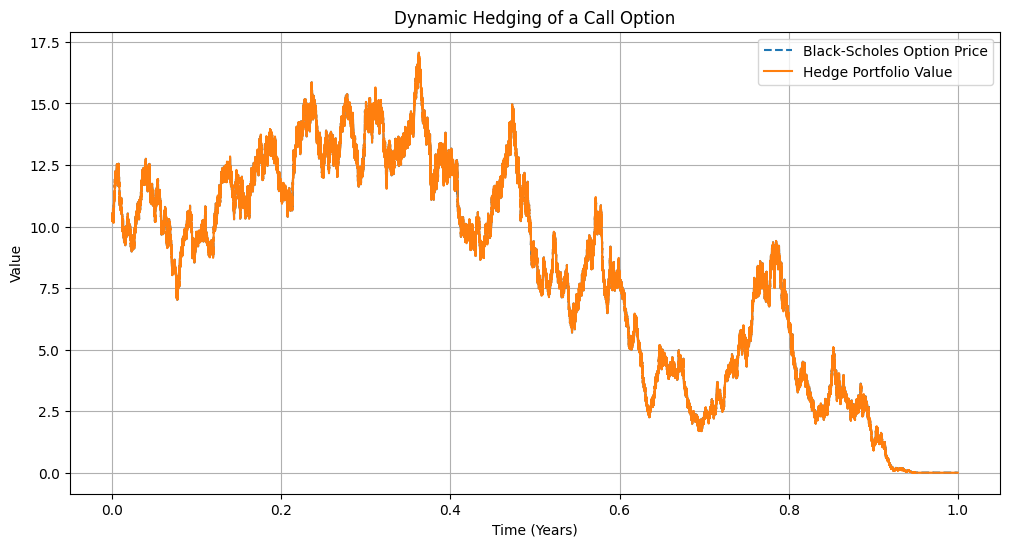

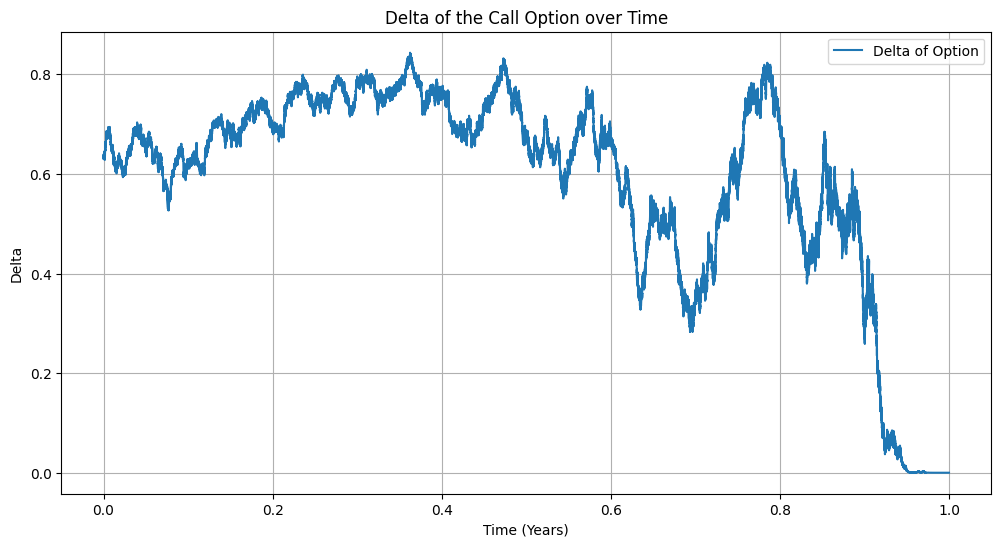

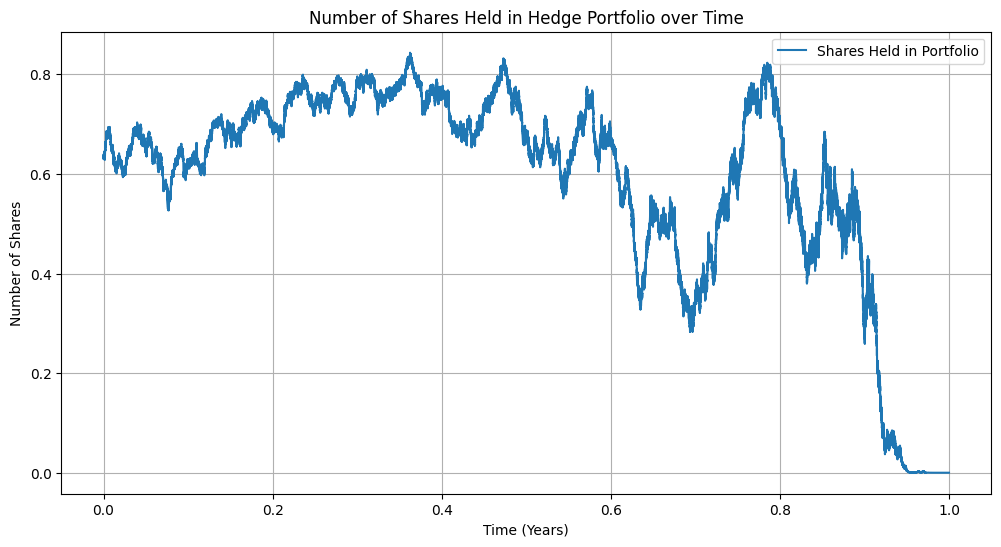

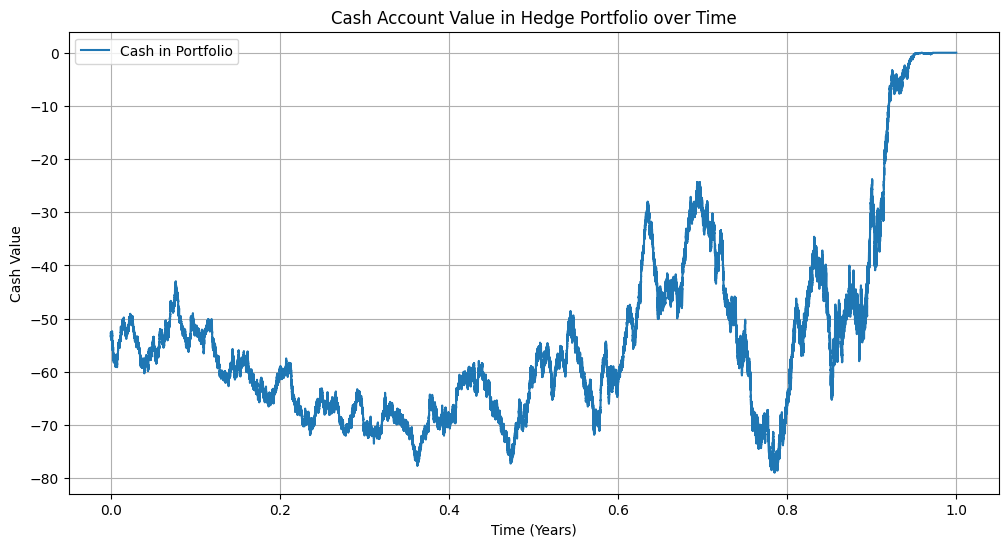

In [68]:
time_axis = np.linspace(0, T, steps + 1)
plt.figure(figsize=(12, 6))
plt.plot(time_axis, option_prices, label='Black-Scholes Option Price', linestyle='--')
plt.plot(time_axis, portfolio_values, label='Hedge Portfolio Value')
plt.xlabel('Time (Years)')
plt.ylabel('Value')
plt.title('Dynamic Hedging of a Call Option')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(time_axis, deltas, label='Delta of Option')
plt.xlabel('Time (Years)')
plt.ylabel('Delta')
plt.title('Delta of the Call Option over Time')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(time_axis, shares_held_list, label='Shares Held in Portfolio')
plt.xlabel('Time (Years)')
plt.ylabel('Number of Shares')
plt.title('Number of Shares Held in Hedge Portfolio over Time')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(time_axis, cash_accounts, label='Cash in Portfolio')
plt.xlabel('Time (Years)')
plt.ylabel('Cash Value')
plt.title('Cash Account Value in Hedge Portfolio over Time')
plt.legend()
plt.grid(True)
plt.show()